In [193]:
from pathlib import Path
import pandas as pd
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [194]:
# ----------------------------------------------
# Paso 1: Cargar y preparar los datasets
# ----------------------------------------------

import pandas as pd

# === Cargar datasets ===
future_logs = pd.read_csv("data/processed/future_stars_cleaned_matchlogs.csv")
future_meta = pd.read_csv("data/processed/future_stars_cleaned_metadata.csv")

print("✅ Datasets cargados:")
print(f"- future_logs: {future_logs.shape}")
print(f"- future_meta: {future_meta.shape}")

# === Validación previa: columnas duplicadas esperadas en el merge ===
cols_logs = set(future_logs.columns)
cols_meta = set(future_meta.columns)
common_cols = cols_logs.intersection(cols_meta)
print("\n🔁 Columnas en común antes del merge:")
print(common_cols)

# === Convertir fechas ===
future_logs['Date'] = pd.to_datetime(future_logs['Date'], format='%Y-%m-%d', errors='coerce')
future_meta['Birth_date'] = pd.to_datetime(future_meta['Birth_date'], format='%Y-%m-%d', errors='coerce')

# === Merge: mantenemos columnas del matchlog en caso de duplicado ===
future_df = future_logs.merge(
    future_meta[['Player_ID', 'Birth_date', 'Position']],
    on='Player_ID',
    how='left'
)

# Eliminar columnas duplicadas del metadata (con sufijo '_y')
duplicated_suffix_cols = [col for col in future_df.columns if col.endswith('_y')]
if duplicated_suffix_cols:
    print("\n⚠️ Columnas duplicadas eliminadas del metadata (sufijo '_y'):")
    print(duplicated_suffix_cols)
    future_df.drop(columns=duplicated_suffix_cols, inplace=True)

# Renombrar columnas '_x' a nombre original
future_df.columns = [col.replace('_x', '') if col.endswith('_x') else col for col in future_df.columns]

# === Calcular edad ===
future_df['Age'] = (future_df['Date'] - future_df['Birth_date']).dt.days / 365.25
# Detectar filas donde 'Player_name' es igual a 'Player Name'
future_df = future_df[future_df['Player_name'] != 'Player Name'].copy()


# === Resumen final ===
print("\n📄 Estructura final del DataFrame combinado:")
print(future_df.shape)
print("\n🧾 Columnas finales del dataset future_df:")
print(future_df.columns.tolist())

# Mostrar muestra de datos
display(future_df.head())




✅ Datasets cargados:
- future_logs: (1053, 46)
- future_meta: (8, 12)

🔁 Columnas en común antes del merge:
{'Position', 'Player_ID', 'Player_name'}

⚠️ Columnas duplicadas eliminadas del metadata (sufijo '_y'):
['Position_y']

📄 Estructura final del DataFrame combinado:
(1052, 48)

🧾 Columnas finales del dataset future_df:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_d

,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc,Birth_date,Age
1,Lamine Yamal,82ec26c1,2022-2023,2023-04-29,Sat,La Liga,Matchweek 32,Home,W 4–0,Barcelona,...,0,8,2,88.9,2,9,0,0,2007-07-13,15.794661
2,Lamine Yamal,82ec26c1,nat_tm,2023-09-08,Fri,UEFA Euro Qualifying,Group stage,Away,W 7–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.156057
3,Lamine Yamal,82ec26c1,nat_tm,2023-09-12,Tue,UEFA Euro Qualifying,Group stage,Home,W 6–0,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.167009
4,Lamine Yamal,82ec26c1,nat_tm,2023-11-16,Thu,UEFA Euro Qualifying,Group stage,Away,W 3–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.344969
5,Lamine Yamal,82ec26c1,nat_tm,2023-11-19,Sun,UEFA Euro Qualifying,Group stage,Home,W 3–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.353183


In [195]:
# ----------------------------------------------
# Paso EDA 1: Análisis estructural inicial del dataset future_df
# ----------------------------------------------

print("✅ Dimensiones del dataset:")
print(f"Filas: {future_df.shape[0]}, Columnas: {future_df.shape[1]}\n")

print("🧾 Columnas del dataset:")
print(future_df.columns.tolist())

print("\n🔍 Tipos de datos:")
display(future_df.dtypes)

print("\n🧼 Conteo de valores nulos por columna:")
display(future_df.isnull().sum().sort_values(ascending=False))

print("\n🧮 Número de valores únicos por columna:")
display(future_df.nunique().sort_values())

print("\n🧪 Muestra aleatoria de 5 filas:")
display(future_df.sample(5, random_state=42))

# Columnas con un único valor (sin variabilidad)
constant_cols = [col for col in future_df.columns if future_df[col].nunique() <= 1]
if constant_cols:
    print("\n⚠️ Columnas constantes (sin valor informativo):")
    print(constant_cols)
else:
    print("\n✅ No hay columnas constantes.")

# Columnas duplicadas
duplicated_cols = future_df.columns[future_df.columns.duplicated()].tolist()
if duplicated_cols:
    print("\n⚠️ Columnas duplicadas:")
    print(duplicated_cols)
else:
    print("\n✅ No hay columnas duplicadas.")


✅ Dimensiones del dataset:
Filas: 1052, Columnas: 48

🧾 Columnas del dataset:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_date', 'Age']

🔍 Tipos de datos:


Player_name                      object
Player_ID                        object
Seasons                          object
Date                     datetime64[ns]
Day                              object
Competition                      object
Round                            object
Home_Away                        object
Result                           object
Player_team                      object
Rival_team                       object
Start                            object
Position                         object
Minutes                          object
Goals                            object
Assists                          object
Penalty_kick                     object
Penalty_kick_att                 object
Shots                            object
Shots_on_target                  object
Yellow_cards                     object
Red_cards                        object
Fouls_committed                  object
Fouls_drawn                      object
Offsides                         object



🧼 Conteo de valores nulos por columna:


Offsides                 1052
Crosses                  1052
Tackles_won              1052
Own_goals                1052
Penaltys_conceded        1052
Penaltys_won             1052
Fouls_drawn              1052
Fouls_committed          1052
Percent_passes            189
x_assisted_G              175
xG                        175
Tackles                   175
Goal_creating_actions     175
Shot_creating_actions     175
Touches                   175
Blocks                    175
Passes_completed          175
Passes_att                175
Progressive_passes        175
Feet_control              175
Progressive_control       175
Dribling_suc              175
non_penalty_xG            175
Position                   77
Interceptions              39
Shots                      39
Shots_on_target            39
Assists                    18
Minutes                     1
Player_name                 0
Player_ID                   0
Day                         0
Goals                       0
Player_tea


🧮 Número de valores únicos por columna:


Offsides                   0
Crosses                    0
Tackles_won                0
Own_goals                  0
Penaltys_conceded          0
Penaltys_won               0
Fouls_drawn                0
Fouls_committed            0
Red_cards                  2
Yellow_cards               2
Penalty_kick               2
Penalty_kick_att           2
Home_Away                  3
Start                      3
Assists                    4
Goals                      4
Interceptions              5
Blocks                     6
Goal_creating_actions      6
Shots_on_target            7
Day                        7
Tackles                    8
Player_ID                  8
Player_name                8
Birth_date                 8
Seasons                   11
Shots                     11
Dribling_suc              14
Shot_creating_actions     14
Progressive_passes        15
x_assisted_G              16
Player_team               16
Progressive_control       16
non_penalty_xG            17
xG            


🧪 Muestra aleatoria de 5 filas:


,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc,Birth_date,Age
97,Lamine Yamal,82ec26c1,2024-2025,2025-01-26,Sun,La Liga,Matchweek 21,Home,W 7–1,Barcelona,...,1,29,9,78.4,3,35,3,5,2007-07-13,17.541410
683,Jamal Musiala,2c0558b8,2021-2022,2021-12-14,Tue,Bundesliga,Matchweek 16,Away,W 5–0,Bayern Munich,...,0,38,2,95.0,5,27,1,1,2003-02-26,18.798084
320,Endrick,a2728fbf,2024-2025,2025-01-19,Sun,La Liga,Matchweek 20,Home,W 4–1,Real Madrid,...,0,3,0,100.0,1,2,0,0,2006-07-21,18.499658
732,Jamal Musiala,2c0558b8,nat_tm,2024-09-07,Sat,UEFA Nations League,League A,Home,W 5–0,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-02-26,21.530459
523,Hugo Ekitike,5b92d896,2023-2024,2023-08-12,Sat,Ligue 1,Matchweek 1,Home,D 0–0,Paris S-G,...,0,7,0,87.5,1,11,0,0,2002-06-20,21.144422



⚠️ Columnas constantes (sin valor informativo):
['Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded']

✅ No hay columnas duplicadas.


In [196]:
print(future_df[['Goals', 'Assists', 'Minutes', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']].dtypes)


Goals              object
Assists            object
Minutes            object
Shots              object
Shots_on_target    object
Yellow_cards       object
Red_cards          object
dtype: object


In [197]:
# Forzar conversión a numérico, convirtiendo strings y NaNs en ceros
cols_to_convert = ['Goals', 'Assists', 'Minutes', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']
future_df[cols_to_convert] = future_df[cols_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0)

# Ahora sí, agregamos
summary_global = future_df[cols_to_convert].sum().to_frame(name='Total')
display(summary_global)


,Total
Goals,231.0
Assists,135.0
Minutes,57041.0
Shots,1690.0
Shots_on_target,652.0
Yellow_cards,82.0
Red_cards,3.0


In [198]:
# ----------------------------------------------
# Desglose por jugador (totales)
# ----------------------------------------------

summary_by_player = future_df.groupby('Player_name').agg({
    'Goals': 'sum',
    'Assists': 'sum',
    'Minutes': 'sum'
}).sort_values('Goals', ascending=False).reset_index()

display(summary_by_player)


,Player_name,Goals,Assists,Minutes
0,Jamal Musiala,77,38.0,16120.0
1,Hugo Ekitike,44,21.0,7802.0
2,Lamine Yamal,27,35.0,8527.0
3,Endrick,27,1.0,3959.0
4,Désiré Doué,21,16.0,6615.0
5,Mathys Tel,19,8.0,3727.0
6,Warren Zaïre-Emery,9,9.0,7591.0
7,Franco Mastantuono,7,7.0,2700.0


C:\Users\juanm\AppData\Local\Temp\ipykernel_20968\1583193433.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_by_player, x='Goals', y='Player_name', palette='Blues_d')
C:\Users\juanm\AppData\Local\Temp\ipykernel_20968\1583193433.py:13: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


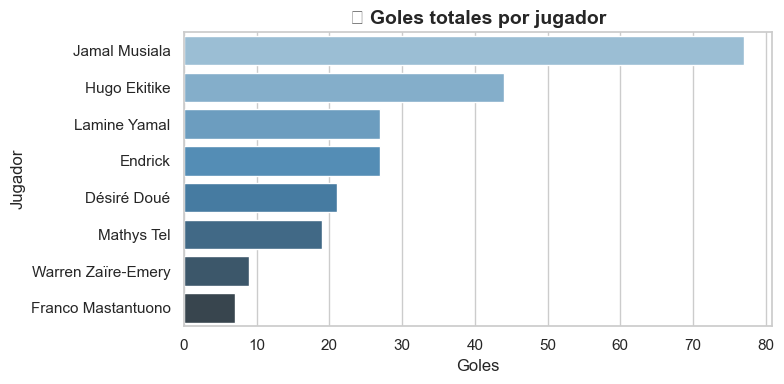

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.barplot(data=summary_by_player, x='Goals', y='Player_name', palette='Blues_d')

plt.title("⚽ Goles totales por jugador", fontsize=14, weight='bold')
plt.xlabel("Goles")
plt.ylabel("Jugador")
plt.tight_layout()
plt.show()


In [200]:
print("🎯 Jugadores disponibles:")
display(future_df[['Player_name', 'Player_ID']].drop_duplicates().reset_index(drop=True))


🎯 Jugadores disponibles:


,Player_name,Player_ID
0,Lamine Yamal,82ec26c1
1,Mathys Tel,829aa60c
2,Endrick,a2728fbf
3,Désiré Doué,9e7483ff
4,Franco Mastantuono,633b2b1f
5,Hugo Ekitike,5b92d896
6,Jamal Musiala,2c0558b8
7,Warren Zaïre-Emery,6b9960cf


In [201]:
# ----------------------------------------------
# Selección de jugador por Player_ID
# ----------------------------------------------

# 👇 Sustituye este ID por el que quieras analizar
player_id = "6b9960cf"

# Extraer nombre solo para mostrar
player_name = future_df.loc[future_df['Player_ID'] == player_id, 'Player_name'].iloc[0]

# Filtrar dataset del jugador
player_df = future_df[future_df['Player_ID'] == player_id].copy()

# Verificación
print(f"🧍 Jugador seleccionado: {player_name} ({player_id})")
display(player_df[['Date', 'Age', 'Minutes', 'Goals', 'Assists']].head())



🧍 Jugador seleccionado: Warren Zaïre-Emery (6b9960cf)


,Date,Age,Minutes,Goals,Assists
927,2022-08-06,16.413415,9.0,0,0.0
928,2022-08-31,16.481862,1.0,0,0.0
929,2022-10-21,16.621492,8.0,0,0.0
930,2022-10-25,16.632444,12.0,0,0.0
931,2022-11-13,16.684463,9.0,0,0.0


In [202]:
# ----------------------------------------------
# EDA básico del jugador seleccionado (sin rating)
# ----------------------------------------------

# Recontar métricas clave
total_matches = len(player_df)
total_minutes = player_df['Minutes'].sum()
total_goals = player_df['Goals'].sum()
total_assists = player_df['Assists'].sum()
total_ga = total_goals + total_assists
total_yellows = player_df['Yellow_cards'].sum()
total_reds = player_df['Red_cards'].sum()

# Por 90 minutos (si hay minutos totales)
goals_per_90 = total_goals / (total_minutes / 90) if total_minutes > 0 else 0
assists_per_90 = total_assists / (total_minutes / 90) if total_minutes > 0 else 0
ga_per_90 = total_ga / (total_minutes / 90) if total_minutes > 0 else 0

# Armar tabla resumen
eda_summary = pd.DataFrame({
    'Total partidos': [total_matches],
    'Minutos totales': [total_minutes],
    'Goles': [total_goals],
    'Asistencias': [total_assists],
    'G+A': [total_ga],
    'Amarillas': [total_yellows],
    'Rojas': [total_reds],
    'Goles/90': [goals_per_90],
    'Asistencias/90': [assists_per_90],
    'G+A/90': [ga_per_90],
})

# Mostrar tabla
print(f"📊 EDA del jugador: {player_df['Player_name'].iloc[0]}")
display(eda_summary)


📊 EDA del jugador: Warren Zaïre-Emery


,Total partidos,Minutos totales,Goles,Asistencias,G+A,Amarillas,Rojas,Goles/90,Asistencias/90,G+A/90
0,126,7591.0,9,9.0,18.0,9,0,0.106705,0.106705,0.213411


In [203]:
# ----------------------------------------------
# Paso 2: Calcular rating_per_90 (manteniendo partidos cortos)
# ----------------------------------------------

# 1. Asegurar tipos numéricos
rating_cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
player_df[rating_cols] = player_df[rating_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# 2. Definir fórmula
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] >= 1 else 0

# 3. Aplicar cálculo a todos los partidos
player_df['rating_per_90'] = player_df.apply(calculate_rating, axis=1)

# 4. Marcar partidos cortos (p.ej. menos de 30 minutos)
player_df['Short_appearance'] = player_df['Minutes'] < 30

# 5. Métricas globales
total_minutes = player_df['Minutes'].sum()
weighted_rating = (player_df['rating_per_90'] * player_df['Minutes']).sum() / total_minutes if total_minutes > 0 else 0

# 6. Mostrar resultados
print(f"\n⏱️ Minutos totales jugados: {int(total_minutes)}")
print(f"🔹 Partidos totales: {len(player_df)}")
print(f"🔸 Partidos cortos (<30min): {player_df['Short_appearance'].sum()}")
print(f"⭐ Weighted rating_per_90: {weighted_rating:.2f}")

# 7. Vista previa
display(player_df[['Date', 'Minutes', 'Goals', 'Assists', 'rating_per_90', 'Short_appearance']].head())





⏱️ Minutos totales jugados: 7591
🔹 Partidos totales: 126
🔸 Partidos cortos (<30min): 37
⭐ Weighted rating_per_90: 1.05


,Date,Minutes,Goals,Assists,rating_per_90,Short_appearance
927,2022-08-06,9.0,0,0.0,0.0,True
928,2022-08-31,1.0,0,0.0,0.0,True
929,2022-10-21,8.0,0,0.0,0.0,True
930,2022-10-25,12.0,0,0.0,0.0,True
931,2022-11-13,9.0,0,0.0,0.0,True


In [204]:
# ----------------------------------------------
# Paso 3: Perfil anual del jugador desde su debut
# ----------------------------------------------

# Asegurar que estamos trabajando sobre el df del jugador
df = player_df.copy()

# 1. Calcular año natural
df['Natural_year'] = df['Date'].dt.year

# 2. Detectar año de debut con minutos jugados
debut_year = df[df['Minutes'] > 0]['Natural_year'].min()

# ⚠️ Validación
if pd.isna(debut_year):
    raise ValueError("❌ El jugador no tiene minutos registrados en ningún año.")

# 3. Año relativo desde debut
df['year_since_debut'] = df['Natural_year'] - debut_year + 1

# 4. Agregación por año
seasonal_agg = df.groupby('year_since_debut').agg({
    'rating_per_90': 'mean',
    'Age': 'mean',
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'Date': 'count'  # número de partidos
}).rename(columns={'Date': 'Matches'}).reset_index()

# 5. Derivar métricas por 90 min
seasonal_agg['goals_per_90'] = seasonal_agg['Goals'] / (seasonal_agg['Minutes'] / 90)
seasonal_agg['assists_per_90'] = seasonal_agg['Assists'] / (seasonal_agg['Minutes'] / 90)
seasonal_agg['ga_per_90'] = (seasonal_agg['Goals'] + seasonal_agg['Assists']) / (seasonal_agg['Minutes'] / 90)

# 6. Pivot para vectorizar
pivot_rating = seasonal_agg.pivot(columns='year_since_debut', values='rating_per_90')
pivot_age = seasonal_agg.pivot(columns='year_since_debut', values='Age')
pivot_minutes = seasonal_agg.pivot(columns='year_since_debut', values='Minutes')

# 7. Renombrar columnas
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 8. Unir en un único perfil vectorizado
player_model_df = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# 9. Variables derivadas (con checks)
if 'rating_year_2' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['growth_2_1'] = player_model_df['rating_year_2'] - player_model_df['rating_year_1']
if 'rating_year_3' in player_model_df.columns and 'rating_year_2' in player_model_df.columns:
    player_model_df['growth_3_2'] = player_model_df['rating_year_3'] - player_model_df['rating_year_2']
if 'rating_year_3' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['rating_trend'] = player_model_df['rating_year_3'] - player_model_df['rating_year_1']
if 'minutes_year_3' in player_model_df.columns and 'minutes_year_1' in player_model_df.columns:
    player_model_df['minutes_trend'] = player_model_df['minutes_year_3'] - player_model_df['minutes_year_1']

# 10. Promedios agregados
player_model_df['avg_rating'] = player_model_df[[col for col in player_model_df.columns if col.startswith('rating_year_')]].mean(axis=1)
player_model_df['sum_minutes'] = player_model_df[[col for col in player_model_df.columns if col.startswith('minutes_year_')]].sum(axis=1)

# 11. Verificación final
print(f"\n🧠 Perfil anual del jugador: {df['Player_name'].iloc[0]}")
display(player_model_df.T)





🧠 Perfil anual del jugador: Warren Zaïre-Emery


,0,1,2,3
rating_year_1,0.000000,NaN,NaN,NaN
rating_year_2,NaN,2.027364,NaN,NaN
rating_year_3,NaN,NaN,0.644696,NaN
rating_year_4,NaN,NaN,NaN,0.411036
age_year_1,16.566735,NaN,NaN,NaN
age_year_2,NaN,17.272684,NaN,NaN
age_year_3,NaN,NaN,18.324274,NaN
age_year_4,NaN,NaN,NaN,19.009126
minutes_year_1,39.000000,NaN,NaN,NaN
minutes_year_2,NaN,2674.000000,NaN,NaN



📊 Estadísticas anuales del jugador:


,year_since_debut,Goals,Assists,Minutes,Matches,G+A
0,1,0,0.0,39.0,5,0.0
1,2,6,5.0,2674.0,46,11.0
2,3,2,3.0,3556.0,51,5.0
3,4,1,1.0,1322.0,24,2.0


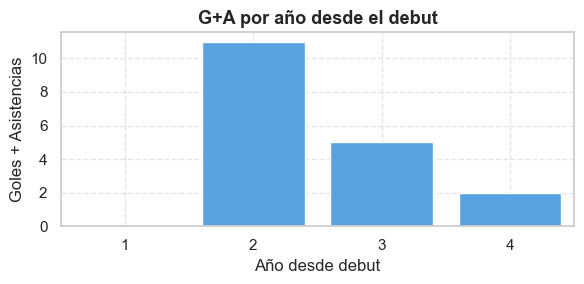

In [205]:
# ----------------------------------------------
# Paso 4: Estadísticas anuales y visualización G+A
# ----------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Asegurar columna 'year_since_debut' está en player_df
if 'year_since_debut' not in player_df.columns:
    player_df['Natural_year'] = player_df['Date'].dt.year
    debut_year = player_df[player_df['Minutes'] > 0]['Natural_year'].min()
    player_df['year_since_debut'] = player_df['Natural_year'] - debut_year + 1

# 2. Agregación anual de métricas
player_stats = player_df.groupby('year_since_debut').agg({
    'Goals': 'sum',
    'Assists': 'sum',
    'Minutes': 'sum',
    'Date': 'count'  # número de partidos
}).rename(columns={'Date': 'Matches'}).reset_index()

player_stats['G+A'] = player_stats['Goals'] + player_stats['Assists']

# 3. Mostrar tabla
print("\n📊 Estadísticas anuales del jugador:")
display(player_stats)

# 4. Gráfico de barras: G+A por año desde el debut
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=player_stats,
    x='year_since_debut',
    y='G+A',
    color="#42a5f5",
    ax=ax
)

ax.set_title("G+A por año desde el debut", fontsize=13, weight='bold')
ax.set_xlabel("Año desde debut")
ax.set_ylabel("Goles + Asistencias")
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()



📊 Minutos anuales del jugador:


,year_since_debut,Minutes,Matches
0,1,39.0,5
1,2,2674.0,46
2,3,3556.0,51
3,4,1322.0,24


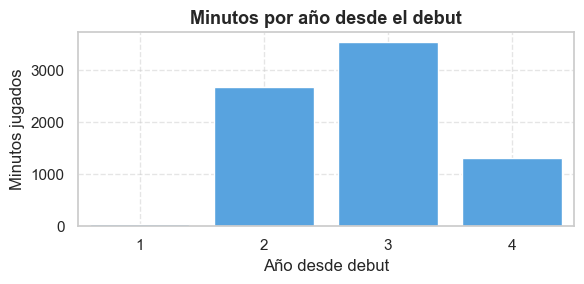

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Asegurar columna 'year_since_debut' está en player_df ---
if 'year_since_debut' not in player_df.columns:
    player_df['Natural_year'] = player_df['Date'].dt.year
    debut_year = player_df.loc[player_df['Minutes'] > 0, 'Natural_year'].min()
    player_df['year_since_debut'] = player_df['Natural_year'] - debut_year + 1

# --- 2. Agregación anual de métricas ---
player_minutes = (
    player_df
    .groupby('year_since_debut')
    .agg(
        Minutes=('Minutes', 'sum'),
        Matches=('Date', 'count')  # número de partidos
    )
    .reset_index()
)

# --- 3. Mostrar tabla ---
print("\n📊 Minutos anuales del jugador:")
display(player_minutes)

# --- 4. Gráfico de barras: Minutos por año desde el debut ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=player_minutes,
    x='year_since_debut',
    y='Minutes',
    color="#42a5f5",
    ax=ax
)

ax.set_title("Minutos por año desde el debut", fontsize=13, weight='bold')
ax.set_xlabel("Año desde debut")
ax.set_ylabel("Minutos jugados")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [207]:
import sys
from pathlib import Path

# Añadir src al path del sistema si no está
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
from stats import get_player_stats

get_player_stats("Warren Zaïre-Emery")

Debut year: 2022
year_since_debut
3    51
2    46
4    24
1     5
Name: count, dtype: int64
            Player_name  Minutes  Goals  Assists       Date
927  Warren Zaïre-Emery        9      0        0 2022-08-06
928  Warren Zaïre-Emery        1      0        0 2022-08-31
929  Warren Zaïre-Emery        8      0        0 2022-10-21
930  Warren Zaïre-Emery       12      0        0 2022-10-25
931  Warren Zaïre-Emery        9      0        0 2022-11-13
Filas totales para Warren Zaïre-Emery: 126
   year_since_debut  Goals  Assists  Minutes  Matches  G+A
0                 1      0        0       39        5    0
1                 2      6        5     2674       46   11
2                 3      2        3     3556       51    5
3                 4      1        1     1322       24    2


,year_since_debut,Goals,Assists,Minutes,Matches,G+A
0,1,0,0,39,5,0
1,2,6,5,2674,46,11
2,3,2,3,3556,51,5
3,4,1,1,1322,24,2


In [208]:
import sys
from pathlib import Path

# Añadir src al path del sistema si no está
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
from model_utils import load_model_assets

model, le, df_curves, model_features = load_model_assets()

In [209]:
import sys
from pathlib import Path

# Añadir src al path del sistema si no está
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from model_utils import load_model_assets
from model_runner import predict_player_group


model, le, _, model_columns = load_model_assets()
pred_label = predict_player_group(model, le, model_columns, player_model_df)

print(f"\n🎯 Predicción del modelo para {player_name}")
print(f"🧠 Grupo estimado: {pred_label}")



🎯 Predicción del modelo para Warren Zaïre-Emery
🧠 Grupo estimado: joven estrella


In [227]:
import sys
from pathlib import Path

# Añadir src al path del sistema si no está
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from model_runner import prepare_features, get_curve_by_group, adjust_projection

player_model_df, player_seasonal = prepare_features(player_id)
pred_label = predict_player_group(model, le, model_features, player_model_df)

group_curve = get_curve_by_group(pred_label)
group_curve = adjust_projection(group_curve, player_seasonal)



In [ ]:
"""import sys
from pathlib import Path

# Añadir src al path del sistema si no está
src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from model_runner import prepare_features, get_curve_by_group, adjust_projection

# 1. Prepara las features (esto ya lo haces bien)
player_model_df, player_seasonal = prepare_features(player_id)

# 2. Saca una sola fila de media, alineada con columnas del modelo
# Esta línea asegura que el resultado tenga solo una fila y columnas correctas
X_input = (
    player_model_df
    .reindex(columns=model_features, fill_value=0)  # <-- rellena las que falten
    .mean(axis=0)
    .to_frame()
    .T
)

# 3. Verifica visualmente
print(f"✅ X_input shape: {X_input.shape}")
print(X_input.T)

# 4. Haz la predicción
pred_encoded = model.predict(X_input)[0]
pred_label = le.inverse_transform([pred_encoded])[0]
print(f"🎯 Predicción: {pred_label}")"""


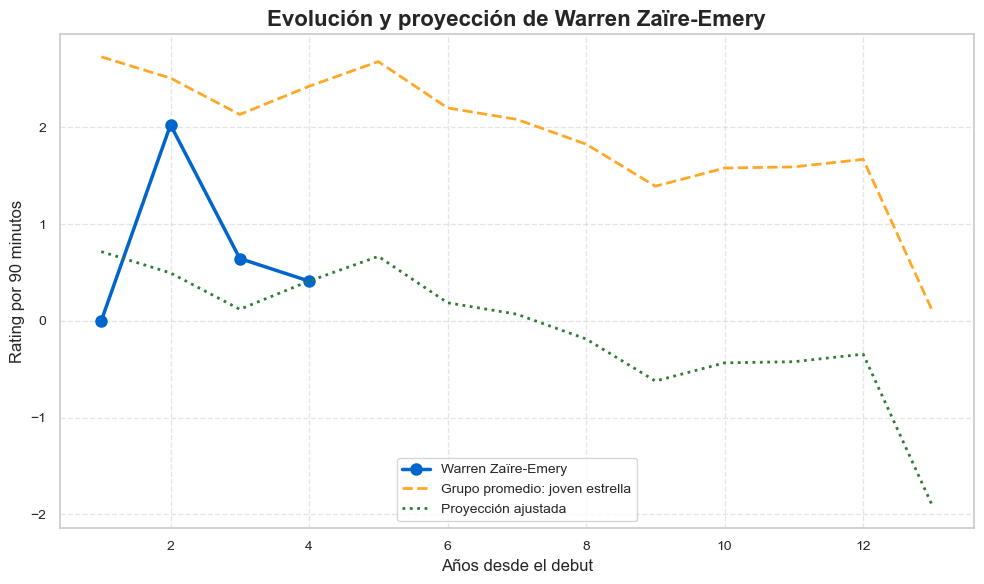

In [228]:
from stats import plot_rating_projection

fig = plot_rating_projection(player_name, player_seasonal, group_curve, pred_label)
plt.show()  # o st.pyplot(fig) en Streamlit


In [212]:
build_player_df("6b9960cf").head()


,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc,Birth_date,Age
0,Warren Zaïre-Emery,6b9960cf,2022-2023,2022-08-06,Sat,Ligue 1,Matchweek 1,Away,W 5–0,Paris S-G,...,0,6,0,100.0,0,4,0,0,2006-03-08,16.413415
1,Warren Zaïre-Emery,6b9960cf,2022-2023,2022-08-31,Wed,Ligue 1,Matchweek 5,Away,W 3–0,Paris S-G,...,0,0,0,NaN,0,0,0,0,2006-03-08,16.481862
2,Warren Zaïre-Emery,6b9960cf,2022-2023,2022-10-21,Fri,Ligue 1,Matchweek 12,Away,W 3–0,Paris S-G,...,0,5,0,100.0,0,5,0,0,2006-03-08,16.621492
3,Warren Zaïre-Emery,6b9960cf,2022-2023,2022-10-25,Tue,Champions Lg,Group stage,Home,W 7–2,Paris S-G,...,0,5,0,100.0,0,5,0,0,2006-03-08,16.632444
4,Warren Zaïre-Emery,6b9960cf,2022-2023,2022-11-13,Sun,Ligue 1,Matchweek 15,Home,W 5–0,Paris S-G,...,0,3,0,100.0,0,4,0,0,2006-03-08,16.684463


In [213]:
# Este es el vector que realmente estás usando
X_input = player_model_df.reindex(columns=model_features, fill_value=0)

print("\n📦 Columnas del modelo:")
print(model_features)

print("\n🎯 Input real pasado al modelo:")
print(X_input.T)



📦 Columnas del modelo:
['rating_year_0', 'rating_year_1', 'rating_year_2', 'rating_year_3', 'age_year_0', 'age_year_1', 'age_year_2', 'age_year_3', 'minutes_year_0', 'minutes_year_1', 'minutes_year_2', 'minutes_year_3', 'minutes_sum', 'minutes_weight_1', 'minutes_weight_2', 'minutes_weight_3', 'growth_2_1', 'growth_3_2', 'avg_rating', 'sum_minutes', 'rating_trend', 'minutes_trend']

🎯 Input real pasado al modelo:
                          0            1            2            3
rating_year_0      0.000000     0.000000     0.000000     0.000000
rating_year_1      0.000000          NaN          NaN          NaN
rating_year_2           NaN     2.027364          NaN          NaN
rating_year_3           NaN          NaN     0.644696          NaN
age_year_0         0.000000     0.000000     0.000000     0.000000
age_year_1        16.566735          NaN          NaN          NaN
age_year_2              NaN    17.272684          NaN          NaN
age_year_3              NaN          NaN    18